## Import libraries

In [114]:
import numpy as np
import tensorflow as tf
import pandas as pd
import statistics
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import data sets**

In [49]:
csv_path_train = '/content/drive/MyDrive/mashrooms-vision/train.csv'
csv_path_test = '/content/drive/MyDrive/mashrooms-vision/test.csv'
images_folder = '/content/drive/MyDrive/mashrooms-vision/dataset/dataset'
output_folder = '/content/drive/MyDrive/mashrooms-vision/sorted/'

In [50]:
train_data = pd.read_csv(csv_path_train)
test_data = pd.read_csv(csv_path_test)

In [56]:
train_data

,Image,Mushroom
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
2360,2367,9
2361,2368,9
2362,2369,9
2363,2370,9


In [57]:
test_data

,Image
0,2372
1,2373
2,2374
3,2375
4,2376
...,...
593,2967
594,2968
595,2969
596,2970


### **Sort images by class**

In [5]:
os.makedirs(output_folder, exist_ok=True)

In [8]:
for _, row in train_data.iterrows():
    image_name = str(row['Image']).zfill(5) + '.jpg'
    label = str(row['Mushroom'])

    src = os.path.join(images_folder, image_name)
    dst_folder = os.path.join(output_folder, label)
    dst = os.path.join(dst_folder, image_name)

    os.makedirs(dst_folder, exist_ok=True)

    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"not found: {src}")

## **Dataset Feature Description**

This dataset contains images of mushrooms, with the goal of classifying them into their respective types. Each entry represents one mushroom, described by the following features:

**ImageID:** The filename or identifier of the mushroom image.

**Mushroom:** The class or type of the mushroom (e.g., Agaricus, Amanita, etc.).

### **Check which mushroom classes are in the dataset and count images per class**

In [55]:
class_order = sorted(train_data['Mushroom'].unique())
class_counts = train_data['Mushroom'].value_counts().reindex(class_order)
print("\nAmount images for each class:")
print(class_counts)


Amount images for each class:
Mushroom
0    238
1    240
2    240
3    222
4    227
5    240
6    238
7    240
8    240
9    240
Name: count, dtype: int64


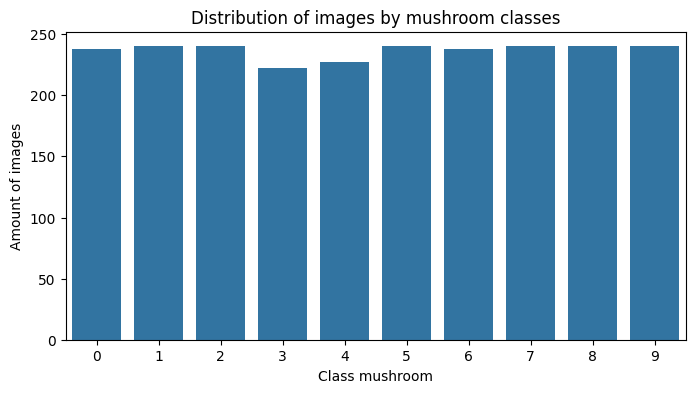

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(x='Mushroom', data=train_data, order=class_order)
plt.title("Distribution of images by mushroom classes")
plt.xlabel("Class mushroom")
plt.ylabel("Amount of images")
plt.show()

###**Check for missing values**

In [64]:
print(train_data.isnull().sum())

Image       0
Mushroom    0
dtype: int64


<Axes: >

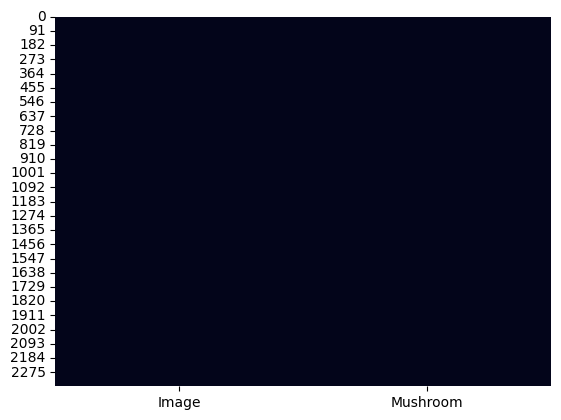

In [65]:
sns.heatmap(train_data.isnull(), cbar=False)

*No missing values in train_data*

In [66]:
print(test_data.isnull().sum())

Image    0
dtype: int64


<Axes: >

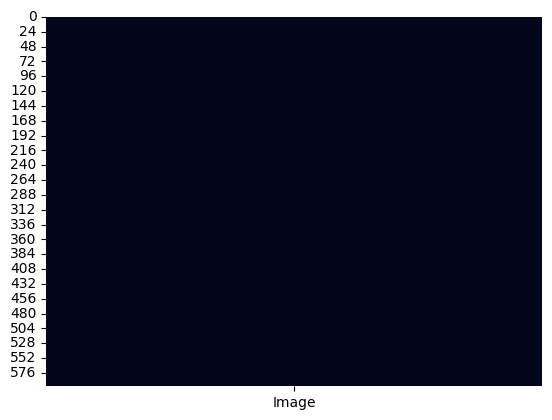

In [67]:
sns.heatmap(test_data.isnull(), cbar=False)

*No missing values in test_data*

### **Check The Duplicates**

In [68]:
train_data.duplicated().sum()

np.int64(0)

In [69]:
test_data.duplicated().sum()

np.int64(0)

*There are no duplicates*

### **Main info about dataset**

In [73]:
train_data.shape

(2365, 2)

In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Image     2365 non-null   int64
 1   Mushroom  2365 non-null   int64
dtypes: int64(2)
memory usage: 37.1 KB


In [71]:
train_data.describe()

,Image,Mushroom
count,2365.000000,2365.000000
mean,1186.930655,4.516702
std,684.671948,2.887527
min,1.000000,0.000000
25%,594.000000,2.000000
50%,1187.000000,5.000000
75%,1780.000000,7.000000
max,2371.000000,9.000000


## **Inspect image properties**

### **Image resolution statistics**

In [117]:
widths, heights = [], []
for img_file in os.listdir(images_folder):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(images_folder, img_file)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

print(f"Min resolution: {min(widths)}x{min(heights)}")
print(f"Max resolution: {max(widths)}x{max(heights)}")

Min resolution: 142x112
Max resolution: 1640x1096


### **Width distribution analysis**

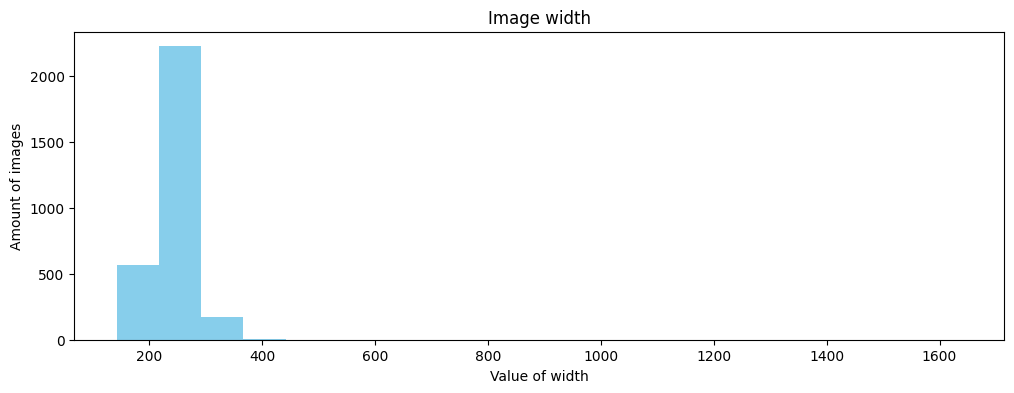

In [120]:
plt.figure(figsize=(12,4))
plt.hist(widths, bins=20, color='skyblue')
plt.title("Image width")
plt.xlabel("Value of width")
plt.ylabel("Amount of images")

plt.show()

In [118]:
print("Most common width:", statistics.mode(widths))

Most common width: 259


### **Height distribution analysis**

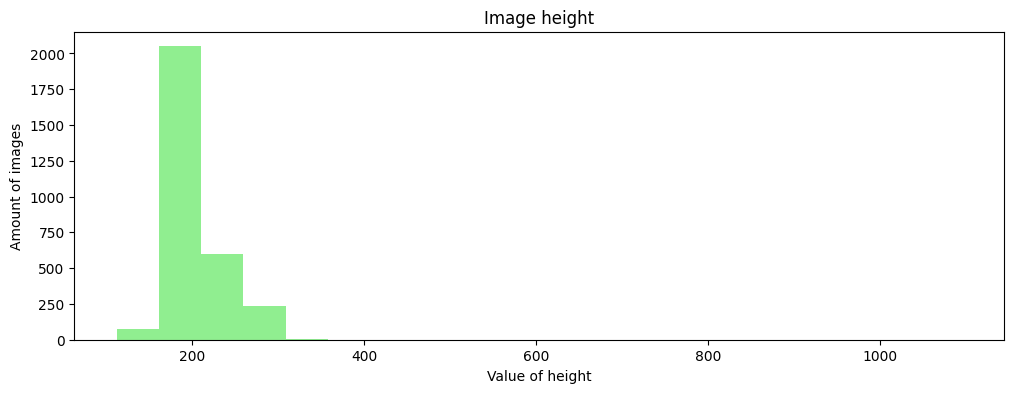

In [109]:
plt.figure(figsize=(12,4))
plt.hist(heights, bins=20, color='lightgreen')
plt.title("Image height")
plt.xlabel("Value of height")
plt.ylabel("Amount of images")

plt.show()

In [119]:
print("Most common height:", statistics.mode(heights))

Most common height: 183


### **Collecting sample images and their properties**

In [121]:
sample_images = []

for class_name in os.listdir(output_folder):
    class_path = os.path.join(output_folder, class_name)
    for img_name in os.listdir(class_path):
        sample_images.append(os.path.join(class_path, img_name))
        break

for img_path in sample_images:
    img = cv2.imread(img_path)
    h, w, c = img.shape
    size_kb = os.path.getsize(img_path) / 1024

    print(f"Image path: {img_path}")
    print(f" - Resolution: {w}x{h}")
    print(f" - Channels: {c}")
    print(f" - File size: {size_kb:.2f} KB\n")


Image: /content/drive/MyDrive/mashrooms-vision/sorted/0/00001.jpg
 - Resolution: 188x268
 - Channels: 3
 - File size: 4.66 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/1/00241.jpg
 - Resolution: 259x194
 - Channels: 3
 - File size: 13.61 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/2/00481.jpg
 - Resolution: 225x225
 - Channels: 3
 - File size: 11.64 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/3/00721.jpg
 - Resolution: 239x211
 - Channels: 3
 - File size: 5.72 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/4/00945.jpg
 - Resolution: 275x183
 - Channels: 3
 - File size: 13.19 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/5/01172.jpg
 - Resolution: 248x203
 - Channels: 3
 - File size: 13.07 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/6/01412.jpg
 - Resolution: 300x168
 - Channels: 3
 - File size: 11.51 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/7/01652.jpg
 - Resolution: 268x188
 - Channels: 3
 -

### **Visualizing one sample image per class**

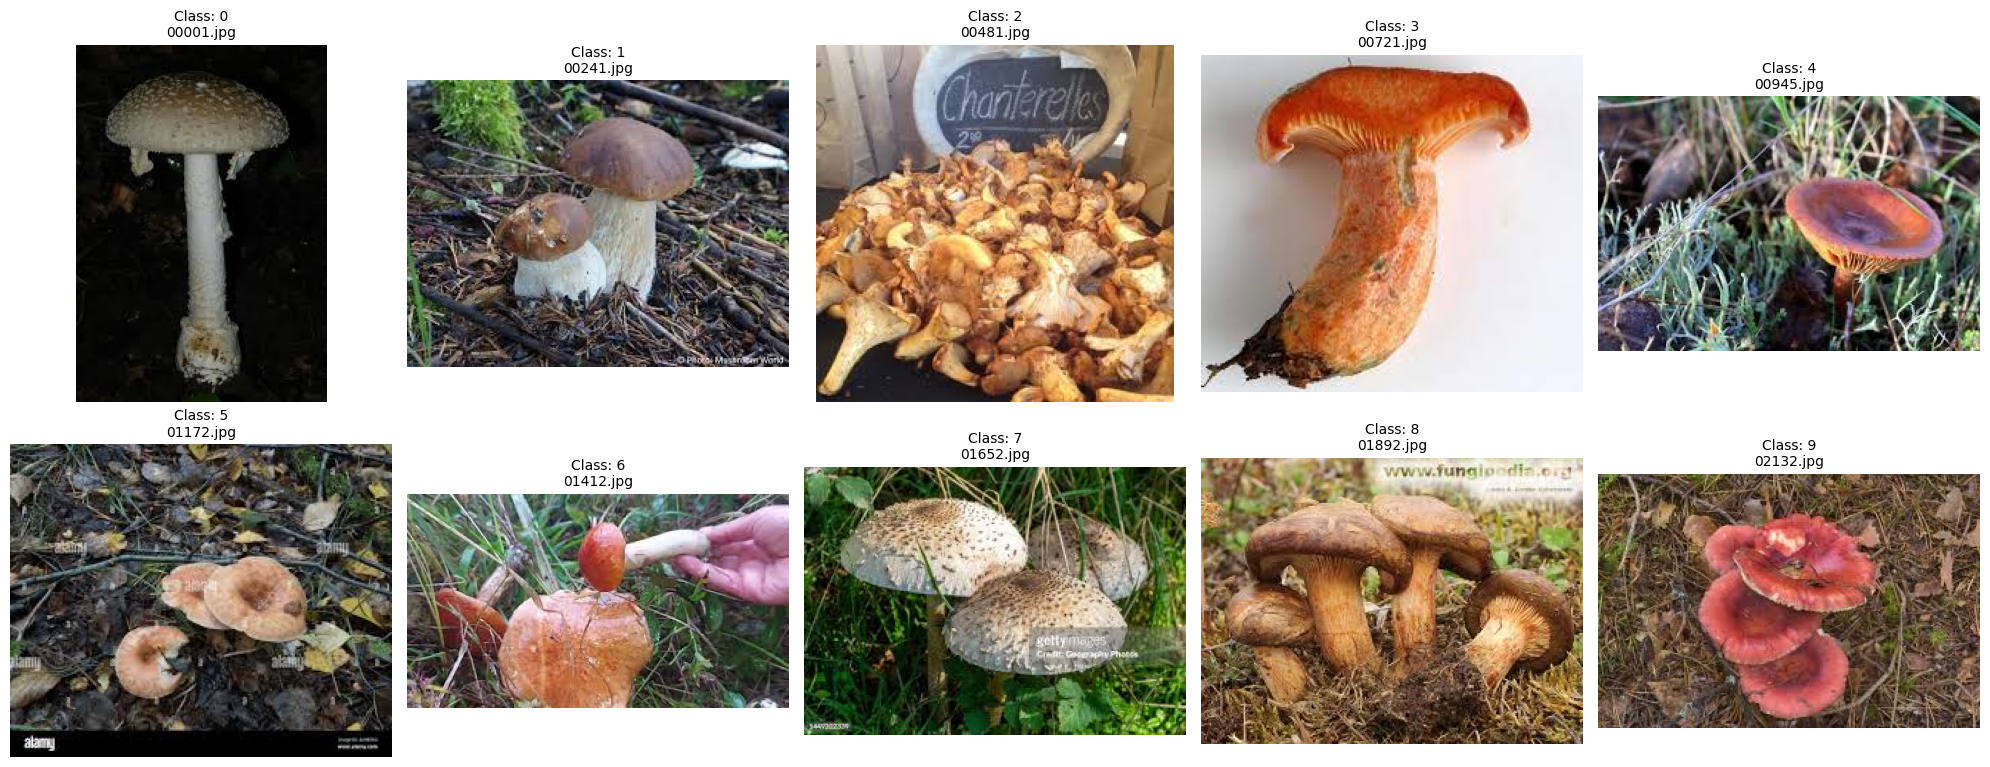

In [124]:
plt.figure(figsize=(20, 8))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    class_name = img_path.split("/")[-2]
    file_name = img_path.split("/")[-1]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n{file_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
